In [78]:
import networkx as nx
import random
import matplotlib.pyplot as plt

In [148]:

def create_random_molecule(num_atoms, include_carboxyl=False):
    # Atom types
    atom_types = ["C", "O", "F", "N", "OH", "S", "Cl", "Br"]
    
    # Initialize the graph
    G = nx.Graph()
    
    # Counter for nodes added
    atom_count = 0
    
    # create a carbon chain of random length
    num_nodes_in_chain = random.randint(num_atoms//2, num_atoms - num_atoms//4)
    
    for i in range(num_nodes_in_chain):
        # Add a carbon atom
        G.add_node(atom_count, atom="C", is_carboxyl=False)
        
        # Connect the carbon atom to the previous atom
        if atom_count > 0:
            G.add_edge(atom_count, atom_count - 1)
        
        atom_count += 1
    
    
    # Add a carboxyl group if required
    if include_carboxyl:
        # Create carboxyl group atoms: O, C, OH
        G.add_node(atom_count, atom="O", is_carboxyl=True)
        atom_count += 1
        G.add_node(atom_count, atom="C", is_carboxyl=True)
        atom_count += 1
        G.add_node(atom_count, atom="OH", is_carboxyl=True)
        atom_count += 1
        
        # Connect the carboxyl group atoms to each other
        G.add_edge(atom_count - 1, atom_count - 2)
        G.add_edge(atom_count - 2, atom_count - 3)
        
        # connec the carbon atom to the first atom in the chain
        G.add_edge(atom_count - 2, 0)
    
    # for the remaining atoms, add them randomly and connect them to the chain; dont use C, OH or O
    
    for i in range(num_atoms - atom_count):
        atom_type = random.choice([x for x in atom_types if x not in ["C", "OH", "O"]])
        
        # Connect the atom to the chain
        node_to_connect = random.randint(0, num_nodes_in_chain - 1)
        
        # ensure the node has degree less than 4
        tries = 0
        while G.degree(node_to_connect) >= 4 and tries < 100:
            node_to_connect = random.randint(0, num_nodes_in_chain - 1)
            tries += 1
        if tries == 100:
            print("Could not add atom")
            break
        G.add_node(atom_count, atom=atom_type, is_carboxyl=False)
        G.add_edge(atom_count, node_to_connect)
        
        atom_count += 1

    # Ensure no cycles are present by converting the graph to a tree
    G = nx.minimum_spanning_tree(G)
    
    return G


In [149]:
def draw_molecule(G):
    # Define color mapping for atom types
    color_map = {
        "C": "black",
        "O": "red",
        "F": "green",
        "N": "blue",
        "OH": "cyan",
        "S": "yellow",
        "Cl": "purple",
        "Br": "orange"
    }
    
    # Assign colors to nodes based on their atom type
    node_colors = ["red" if G.nodes[node]['is_carboxyl'] else color_map[G.nodes[node]['atom']] for node in G.nodes]
    # Define node labels as atom types
    node_labels = {node: G.nodes[node]['atom'] for node in G.nodes}
    
    # Draw the graph
    pos = nx.spring_layout(G)  # Position the nodes using spring layout
    nx.draw(G, pos, node_color=node_colors, with_labels=True, labels=node_labels, node_size=800, font_size=10, font_color="white")
    
    plt.show()

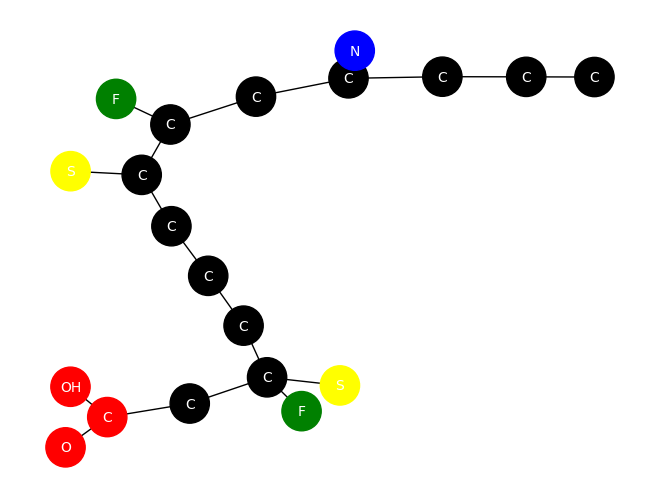

In [156]:
G = create_random_molecule(num_atoms=20, include_carboxyl=True)

# Draw the graph
draw_molecule(G)

In [159]:
# make pyg graph
import torch
import pprint

edge_index = torch.tensor(list(G.edges)).t().contiguous()

pprint.pprint(edge_index)

tensor([[ 0,  0,  1,  1,  1,  2,  3,  4,  5,  5,  6,  6,  7,  8,  8,  9, 10, 12,
         13],
        [ 1, 13,  2, 15, 16,  3,  4,  5,  6, 17,  7, 18,  8,  9, 19, 10, 11, 13,
         14]])


In [ ]:
 # check if it undirected
edge_index = torch.cat([edge_index, edge_index[[1, 0]]], dim=1)

pprint.pprint(edge_index)